# Assignment 2: Natural Disasters Dataset

# Introduction

(I wish to thank the reader(s) for taking the time to read and review my work, I hope they find it interesting and enjoy going over it! I wrote this report by imagining that my clients were in the charity/help sector and trying to send help to natural disaster sites as soon as possible by using tweets as a proxy to find where natural disasters happened. They are referred to as "The Organization" in this report)

Assumptions made: 

- The keyword and location columns are not used, since it's never mentioned as an input to the models and it being a text classification exercise.

## The Problem

Natural disasters happen around the clock all around the world. The Organization is looking to help as many victims of those events as possible, and they found themselves scrolling through numerous Tweets everyday to try to find new natural disasters happening where they could offer help. This is time consuming, and therefore costly, as The Organization's resources would be better served going on the field and assisting people. 


## The Proposed Solution

It was assessed that developing a tool (ie. Machine Learning model) to separate between Tweets that are likely about natural disasters and those who aren't would greatly reduce the time spent sifting through Tweets, and improve the responsiveness of The Organizaton. Due to the critical nature of this tool, **understandability is critical**. 

The Organization wants to train and evaluate **3 different supervised machine learning algorithms**.
A measure of performances has not been defined, and different options will be explored, in order to align with the business objectives.

The 3 different proposed methods are:
- Bag of words model
- TF-IDF and traditional model
- Pre-trained word embeddings + linear classifier model


## The Data

Fortunately for The Organization and its data scientists, a publicly available, labelled dataset of Tweets that are about natural disasters and not. (https://www.kaggle.com/competitions/nlp-getting-started/)

From the source, we find that each row in the dataset contains:
- The *text* of a tweet
- A *keyword* from that tweet (might be blank, and there is not more information about what constitute a keyword)
- The *location* from where the tweet was sent (can also be blank)

Because there is not way to know how the *keyword* data is extracted, The Organization decided not to use this feature in the model and focus on the Tweet's text directly.


# Setup

In [1]:
## Imports
import sys
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from string import punctuation

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "disasters_dataset"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

## Load the Data

In [2]:
## Loading the data
data_PATH = os.path.join("datasets", "disasters")



def load_data(filename, data_path=data_PATH):
    file_path = os.path.join(data_path, filename)
    return pd.read_csv(file_path)

train_data = load_data(filename ="train.csv")
test_data = load_data(filename ="test.csv")

In [3]:
train_data

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

## Data Exploration

Since the data is already split between train and test sets, we can jump right in with exploring the train dataset to understand it better. 

Looked at 20 rows somewhere in the dataframe because the first few rows are all about disaster Tweets.

In [4]:
train_data[500:520]

id    keyword                        location  \
500  725   attacked                LEALMAN, FLORIDA   
501  726   attacked                 Los Angeles, CA   
502  727   attacked               San Francisco, CA   
503  728   attacked                     #GDJB #ASOT   
504  729   attacked  Groningen, Netherlands, Europe   
505  730   attacked          Livingston, IL  U.S.A.   
506  731   attacked                        Arundel    
507  732   attacked                             NaN   
508  734   attacked                         America   
509  735   attacked                  Anna Maria, FL   
510  736   attacked                             USA   
511  737   attacked                          israel   
512  738   attacked            The Hammock, FL, USA   
513  739   attacked              ??????????????????   
514  740   attacked          SÌ£o Paulo SP,  Brasil   
515  744   attacked               in Dimitri's arms   
516  745   attacked                    Oslo, Norway   
517  746  avalanche                     Los Angeles   
518  748  avalanche             Loughton, Essex, UK   
519  751  avalanche                      guaravitas   

                                                  text  target  
500  Christian Attacked by Muslims at the Temple Mo...       1  
501  @envw98 @NickCoCoFree @JulieDiCaro @jdabe80 Wh...       0  
502  Kelly Osbourne attacked for racist Donald Trum...       1  
503  @eunice_njoki aiii she needs to chill and answ...       0  
504  Christian Attacked by Muslims at the Temple Mo...       1  
505  Christian Attacked by Muslims at the Temple Mo...       1  
506  Christian Attacked by Muslims at the Temple Mo...       1  
507  I attacked Robot-lvl 19 and I've earned a tota...       0  
508  Christian Attacked by Muslims at the Temple Mo...       1  
509  @christinalavv @lindsay_wynn3 I just saw these...       0  
510  Christian Attacked by Muslims at the Temple Mo...       1  
511  Christian Attacked by Muslims at the Temple Mo...       1  
512  Christian Attacked by Muslims at the Temple Mo...       1  
513  TV program I saw said US air plane flew to ura...       1  
514  Christian Attacked by Muslims at the Temple Mo...       1  
515  @MageAvexis &lt; things. And what if we get at...       0  
516  Christian Attacked by Muslims at the Temple Mo...       1  
517  #WeLoveLA #NHLDucks Avalanche Defense: How The...       0  
518  I liked a @YouTube video http://t.co/TNXQuOr1w...       0  
519                 we'll crash down like an avalanche       0

It looks like users can set their *location* to anything, from fictional places to no location to countries to cities. 

From the *text* column, a lot of punctuation is used (at sign, hashtags, etc.) as well as URLs and capitalizations and contractions. 

Let's take a look at more information about the dataframe.

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


There is a *keyword* for all but 61 Tweets (99.2% of Tweets contain a keyword). Location is also often present (66.7% of Tweets).

Let's look at the target data's mean:

In [6]:
train_data["target"].mean()

0.4296597924602653

42.97% of Tweets are from real natural disasters. This dataset is not very skewed and a simple measure of accuracy might be good enough to report. This is a nice baseline and objective to beat though, since identifying all Tweets as "not a natural disaster" would achieve a 57.03% accuracy.

While we won't be using the *keyword* column, it looks like it could contain interesting data to explore. Let's see if we can understand the it a little better:

In [7]:
train_data['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

There are 221 different keywords. Let's see if some have higher shares of natural disasters:

In [8]:
keyword_disasters = train_data.groupby('keyword').agg(
    Mean=('target', np.mean)).sort_values(by='Mean')

keyword_disasters.head(10)

Mean
keyword              
aftershock   0.000000
body%20bags  0.024390
ruin         0.027027
blazing      0.029412
body%20bag   0.030303
electrocute  0.031250
screaming    0.055556
traumatised  0.057143
panicking    0.060606
blew%20up    0.060606

In [9]:
keyword_disasters.tail(10)

Mean
keyword                    
suicide%20bomb     0.914286
bombing            0.931034
suicide%20bomber   0.967742
suicide%20bombing  0.969697
oil%20spill        0.973684
typhoon            0.973684
outbreak           0.975000
debris             1.000000
wreckage           1.000000
derailment         1.000000

From the above, it does look like some of the keywords in the *keyword* column could indicate disasters - hopefully the additional context of the full Tweets will help better the model. This column could also be used as a cheap baseline for the accuracy value, perhaps better than the naive one of 57.03% considered earlier.

As a final data exploration step, let's find the minimum and maximum length of a Tweet:


In [10]:
train_data.text.str.len().min()

7

In [11]:
train_data.text.str.len().max()

157

Tweets vary between 7 and 157 characters. The difference is not too big, it will be interesting to see how the frequency-based TF-IDF model performs vs the bag of words model.

Let's visualize how many words are in each tweet (for the visualization to be colour-blind friendly, blue and orange were chosen to distinguish between disasters and not disasters):

### Exploring Words

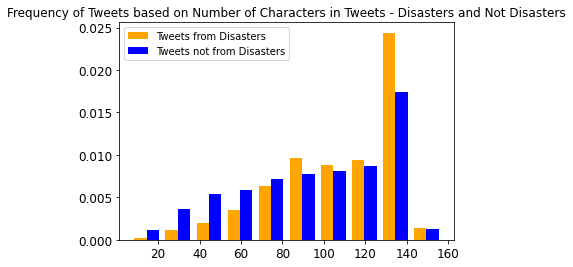

In [12]:
plt.figure()

labels = ['Tweets from Disasters', 'Tweets not from Disasters']
colours = ['orange', 'blue']

text_len_disasters=train_data[train_data['target'] == 1]['text'].str.len()
text_len_not = train_data[train_data['target'] == 0]['text'].str.len()

plt.hist([text_len_disasters, text_len_not], stacked=False, density=True, color=colours, label=labels)
plt.legend()
plt.title('Frequency of Tweets based on Number of Characters in Tweets - Disasters and Not Disasters')

plt.show()

From the above visualization, it looks like Tweets from disasters contains, overall, more words than Tweets not from disasters

Let's analyze which words are most popular in Tweets, called stop words, that we might want to remove if they appear in both types of Tweets. If they appear all the time for both types of Tweets, these words aren't gonna be super useful in helping us classify disaster Tweeets from non-disaster ones.

In [13]:
def find_all_words(data, target_value):
    # find_all_words takes a dataset data, and the target column's value (0 or 1) and outputs a list of all the words 
    #     for the 'text' column in the dataset.
    # Here, words are separated by a space.
    all_words = []
    # Go through all the text value, split by space
    for text_split in data[data['target']==target_value]['text'].str.split():
        for word in text_split:
            all_words.append(word)
    return all_words


Let's look at the most popular words for both disaster and non-disaster tweets:

In [14]:
# Create the list of words
all_words_disasters = find_all_words(train_data, 1)
all_words_not = find_all_words(train_data, 0)

## Build a dictionary to count occurences of words
def count_unique_words(list_of_words):
    # count_unique_words takes a list of strings (list_of_words) and outputs a dictionary with strings as key and the count as value
    output_dict = {}
    for word in list_of_words:
        if word in output_dict:
            output_dict[word] += 1
        else:
            output_dict.setdefault(word, 1)
    return output_dict

all_words_disasters_dict = count_unique_words(all_words_disasters)
all_words_not_dict = count_unique_words(all_words_not)

In [15]:
top_10_disaster_words = sorted(all_words_disasters_dict.items(), key=lambda x:x[1],reverse=True)[:10] 
top_10_not_words = sorted(all_words_not_dict.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

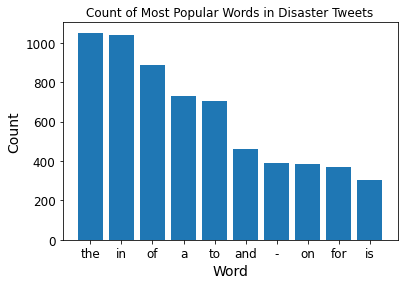

In [16]:
x,y =zip(*top_10_disaster_words)
plt.figure()
plt.title("Count of Most Popular Words in Disaster Tweets")
plt.xlabel("Word")
plt.ylabel("Count")
plt.bar(x,y)

<BarContainer object of 10 artists>

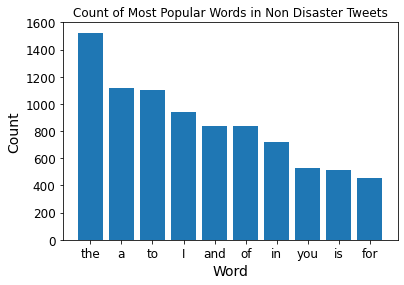

In [17]:
x,y =zip(*top_10_not_words)
plt.figure()
plt.title("Count of Most Popular Words in Non Disaster Tweets")
plt.xlabel("Word")
plt.ylabel("Count")
plt.bar(x,y)

From these lists, we see that common English words like "The", "a", "in" are in a lot of tweets that are both disasters and non-disasters tweets. They probably aren't informative.

Before jumping in data preparation, let's remove the labels from the data.

In [64]:
X_train, y_train = train_data.drop(["keyword", "location", "target"], axis=1), train_data["target"].copy()

# Bag of Words Model

Time to build the first model using a bag of words representation. The bag of words' aim is to make the text data of the Tweets ingestible for a ML model, ie. to transorm it into numerical values.

To do this, we look at each word present in all the Tweets, and for each Tweet, we count how many of this word appears.

To that end, data preparation and cleaning is super important. For example, capitalization could create more words than necessary - "Fire" and "fire" are the same word, we don't want to count them separately.

## Data Preparation

For preprocessing the data, we need to clean the text as much as possible to obtain informative features.
From what we explored:
- We should remove non-informative words
Non-informative words such as "the", "in" etc. are extremely popular words, whether they are Disaster Tweets or not. By removing them, we hope to keep mostly informative words. 

As a future task, training with and without this preprocessing step could be tried.

- Cases need to be uniform, let's lower case the whole text

We want to reduce the number of features to train the dataset on, which will already have a lot of features. Having "Fire" and "fire" as different words might have us lose information on that word.

- If any accents are present, let's remove them

Some languages have accents (like French), and people sometimes write online with or without the proper accents. Like the lower case issue, we don't want to lose signal on the words because the same words are written with or without accents.

- Remove punctuation if present

We do not want punctuation to impede with the information in a word. From Tweets, there are gonna be a lot of hashtags for example.

- Replace numbers

Replacing numbers to NUMBER.




In [65]:
from sklearn.base import BaseEstimator, TransformerMixin
import urlextract
import re
    
url_extractor = urlextract.URLExtract()

class TweetsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True):
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers

    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        newtext = []
        for Tweets in X['text']:
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(Tweets)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    Tweets = Tweets.replace(url, " URL ")
            if self.replace_numbers:
                Tweets = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', Tweets)
            if self.remove_punctuation:
                Tweets = re.sub(r'\W+', ' ', Tweets, flags=re.M)
            newtext.append(Tweets)
        X['text'] = newtext
        return X['text']

In [66]:
## Let's create a preprocessing pipeline with sklearn and use CountVectorizer for the preprocessing steps
text_pipeline = Pipeline([
    ('tweets_preprocessing', TweetsTransformer()),
    ('count_vectorizer', CountVectorizer(strip_accents = 'unicode', lowercase = True, stop_words = 'english'))
])

In [67]:
X_train_vectors = text_pipeline.fit_transform(X_train)

For the model, we will train a simple Decision Tree. A decision tree is visualizable and simple to explain. 

In this case, for each node, the tree looks at a word that splits the data the best between Disasters and Not Disaster Tweets.

In [73]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train_vectors, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Let's evaluate this classifier using cross-validation and accuracy as a measure of error.

In [74]:
from sklearn.model_selection import cross_val_score
bow_tree_cv = cross_val_score(tree_clf, X_train_vectors, y_train, cv=5, scoring="accuracy")
bow_tree_cv

array([0.60801051, 0.59093894, 0.61851609, 0.61563732, 0.66557162])

Let's compute the precision and recall

In [75]:
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(tree_clf, X_train_vectors, y_train, cv=5)

In [76]:
bow_tree_precision = precision_score(y_train, y_train_pred)
bow_tree_precision

0.5469296055916126

In [77]:
bow_tree_recall = recall_score(y_train, y_train_pred)
bow_tree_recall

0.6698257413634974

The model has an accuracy of slightly over 60% accorrding to the cross validation, which is not much better than a naive mode where we would identify all Tweets as Not Disasters (57% accuracy). However, where the naive model would fail to identify any true disaster, our decision tree can identify 66% of all the real disaster Tweets. And 54% of what it considers a disaster Tweet is actually one. 

Keeping in mind that this decision tree isn't tuned, we can also visualize it:

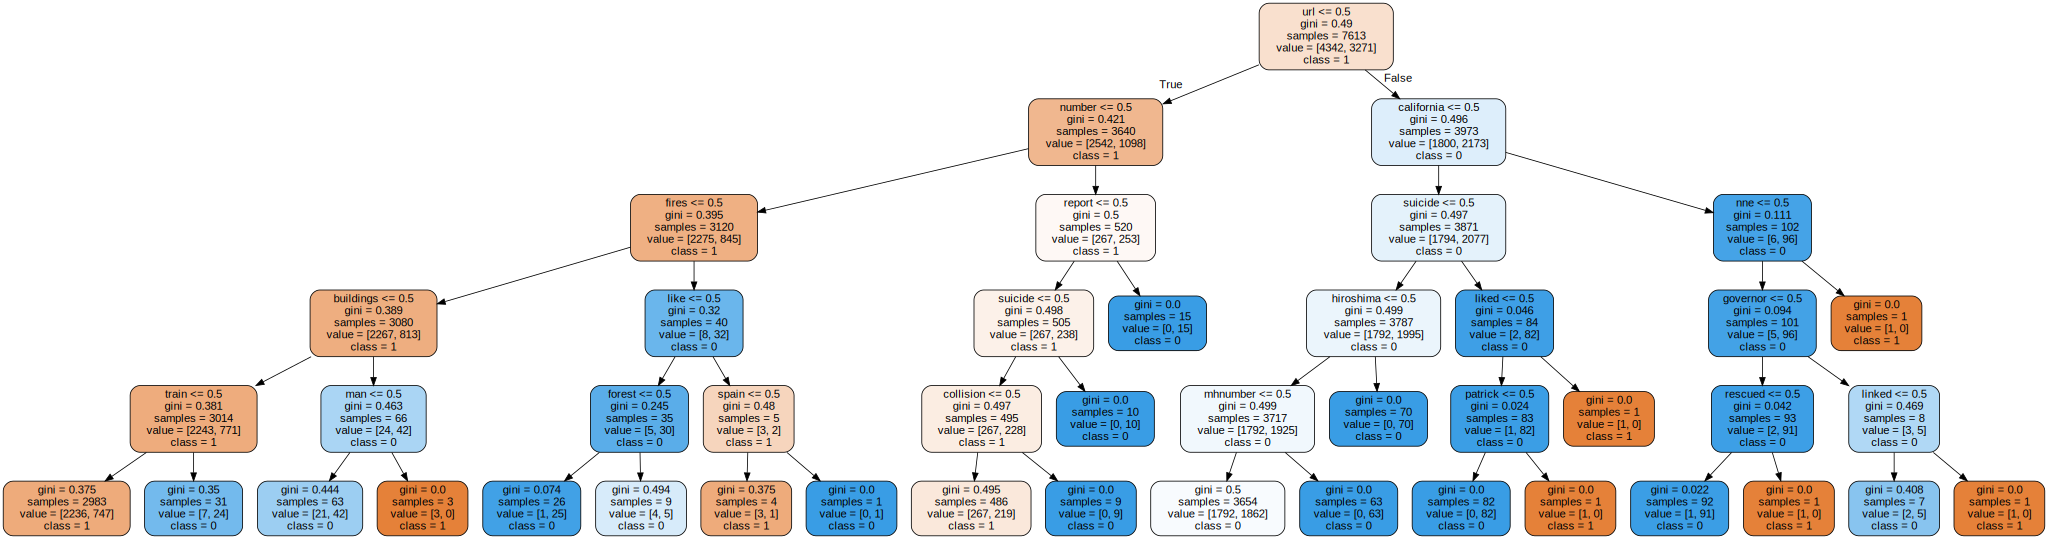

In [27]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(tree_clf,
                out_file=os.path.join(IMAGES_PATH, "disaster_tweet.dot"),
               feature_names=text_pipeline['count_vectorizer'].get_feature_names_out(),
               class_names=y_train.unique().astype('str'),
               rounded=True,
               filled=True)

Source.from_file(os.path.join(IMAGES_PATH, "disaster_tweet.dot"))

Above is a single decision tree with a maximum depth of 5 nodes. If we follow one path, we should be able to understand how the tree classified the tweets.

For example, the classifier found that Tweets containing the words "http", "new", "york", and not the word "plaza" had 11 cases of Non Disaster Tweets and would therefore classify future Tweets satisfying those conditions as "Not Disaster". If it contained "plaza" however, it would classify those Tweets as "Disaster". 

# TF-IDF Model

The TD-IDF feature generator stands for "Term Frequency times Inverse Document Frequency", and calculates the frequency of a word appearing in each Tweet, rather than calculating the count like in the Bag of Word feature generator.

For this next model, we will build on the Decision Tree by trying a RandomForest model. The random forest model tries a bunch of different Decision Trees and aggregates the results to classify the Tweet. 

Since it is more free to explore the wide range of features that TF-IDF will create, it should improve on the Decision Tree's accuracy.

We are re-using the preprocessing steps from before. 

In [78]:
from sklearn.feature_extraction.text import TfidfTransformer
## Let's create a preprocessing pipeline with sklearn and use TfidfTransformer

text_pipeline_tfidf = Pipeline([
    ('tweets_preprocessing', TweetsTransformer()),
    ('count_vectorizer', CountVectorizer(strip_accents = 'unicode', lowercase = True, stop_words = 'english')),
    ('tf_idf_transformer', TfidfTransformer(use_idf=True))
])




In [79]:
X_train_vectors = text_pipeline_tfidf.fit_transform(X_train)

In [109]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train_vectors, y_train)

RandomForestClassifier(random_state=42)

In [83]:
tfidf_rnd_cv = cross_val_score(rnd_clf, X_train_vectors, y_train, cv=5, scoring="accuracy")
tfidf_rnd_cv

array([0.70387393, 0.6093237 , 0.60801051, 0.65703022, 0.73784494])

In [84]:
y_train_pred = cross_val_predict(rnd_clf, X_train_vectors, y_train, cv=5)

In [85]:
tfidf_rnd_precision = precision_score(y_train, y_train_pred)
tfidf_rnd_precision

0.6969359331476324

In [86]:
tfidf_rnd_recall = recall_score(y_train, y_train_pred)
tfidf_rnd_recall

0.3824518495872822

This doesn't look great! While the accuracy has gone up on average, our recall (correctly identifying true Disaster Tweets) has gone down to 38.4%. The good news though, is that when the ML models identifies a Tweet as a "Disaster", it is correct 69.6% of the time, up from 54.7%! This could be really useful if The Organization is ok with not being able to identify all disasters, but being able to idenfify them precisely.

# Pre-Trained Word Embeddings

We will use the pre-trained corpus model of GloVe to hopefully improve our classifier. For computing reason, we will pick the 50 dimensional version of GloVe.

We will transform the data using the TweetsTransformer class to clean words, and build a list of words for GloVe.


In [35]:
from zeugma.embeddings import EmbeddingTransformer

2022-12-03 21:16:24.030407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 21:16:24.030620: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [36]:
glove = EmbeddingTransformer('glove')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [45]:
X_glove = TweetsTransformer().fit_transform(X_train)

In [46]:
X_glove = glove.transform(X_glove)

In [108]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, random_state=42)
sgd_clf.fit(X_glove, y_train)

SGDClassifier(random_state=42)

In [87]:
glove_sgd_cv = cross_val_score(sgd_clf, X_glove, y_train, cv=5, scoring="accuracy")
glove_sgd_cv

array([0.75377544, 0.7209455 , 0.73473408, 0.6892247 , 0.75821288])

In [88]:
y_train_pred = cross_val_predict(sgd_clf, X_glove, y_train, cv=5)

In [92]:
glove_sgd_precision = precision_score(y_train, y_train_pred)
glove_sgd_precision

0.7309721175584024

In [93]:
glove_sgd_recall = recall_score(y_train, y_train_pred)
glove_sgd_recall

0.5930907979211251

This model is looking like the most promising in terms of accuracy, prediction and recall. It is also more consistent in its accuracy and could perform better on new data.

In [101]:
## Merging metrics together for a final plot
bow = ["Bag of Words - Tree", bow_tree_cv.mean(), bow_tree_precision, bow_tree_recall]
tf_idf = ["TF-IDF Random Forest", tfidf_rnd_cv.mean(), tfidf_rnd_precision, tfidf_rnd_recall]
glove = ["GloVe - SGD Classifier",glove_sgd_cv.mean(), glove_sgd_precision, glove_sgd_recall]


metrics = pd.DataFrame([bow, tf_idf, glove], columns=["test_name", "cv_accuracy", "precision", "recall"])

In [103]:
metrics

test_name  cv_accuracy  precision    recall
0     Bag of Words - Tree     0.619735   0.546930  0.669826
1    TF-IDF Random Forest     0.663217   0.696936  0.382452
2  GloVe - SGD Classifier     0.731379   0.730972  0.593091

# Recommendations to the Clients

As things stands, I would recommend to the client to use the Random Forest classifier. The reason being, it has the 2nd best precision and accuracy out of the three models. Which could be important in the scenario that The Organization wants to eliminate time sifting through Tweets - 69.7% of the positives returned by the classifier would be Tweets from true disasters. 

This does sacrifices some true disasters that are missed by the classifier more often than when using other models. See below the bar charts comparing the different metrics.

The Glove SGD classifier shines in accuracy, precision and recall metrics. However, it is not easy to interpret. First, the preprocessing step maps the words in the Tweets to vectors according to an external, unsupervised learning algorithm - which is fine mathematically, but is difficult to explain the different values that different words are attributed. (Description found here: https://nlp.stanford.edu/projects/glove/). In addition, because the project is maintained externally, if it ever stopped, or if the model's quality dropped, The Organization would be in trouble with regards to our own model. 

The Random Forest model is not as simple to interpret as the Decision Tree one, but the idea is still intuitive enough to understand, and one can output the feature importances to understand which words are impacting decisions the most. The preprocessing being made in-house also has the advantage that The Organization can tuneeit to its liking. 


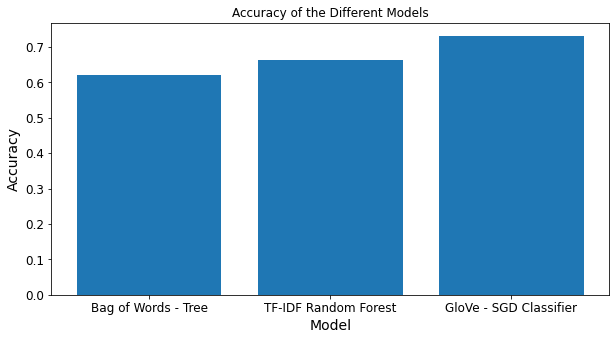

In [118]:

plt.figure(figsize=(10,5))
plt.title("Accuracy of the Different Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.bar(metrics["test_name"], metrics['cv_accuracy'])

plt.show()

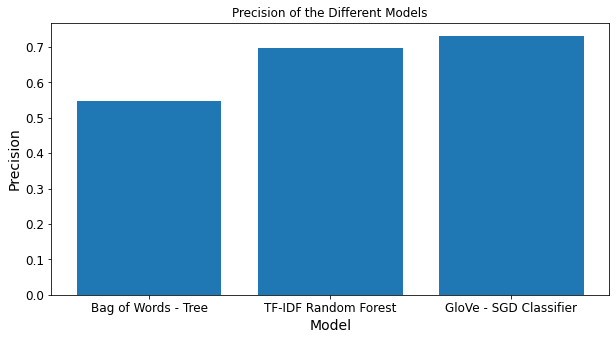

In [119]:
plt.figure(figsize=(10,5))
plt.title("Precision of the Different Models")
plt.xlabel("Model")
plt.ylabel("Precision")
plt.bar(metrics["test_name"], metrics['precision'])

plt.show()

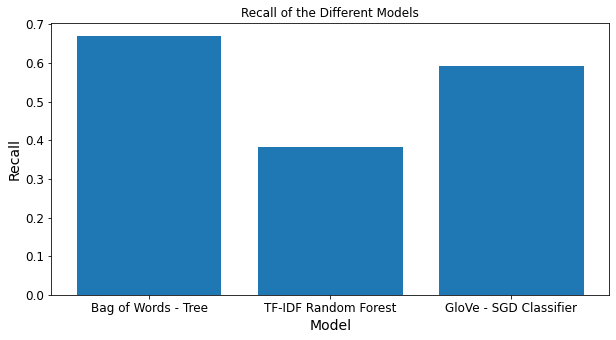

In [120]:
plt.figure(figsize=(10,5))
plt.title("Recall of the Different Models")
plt.xlabel("Model")
plt.ylabel("Recall")
plt.bar(metrics["test_name"], metrics['recall'])

plt.show()

# How I might have done things Differently

This assignment was pretty fun! I'm glad to have picked Assignment 2, as it seemed like it allowed for more freedom, exploration and creativity regarding the manipulation of data and choosing the models. 

I did find a little awkward to train a different model on each different pre-processing of the data (bag of word, TF-IDF, and pre-trained word embeddings). It seems like, to make a fair comparison of each method, we would want to test them all on the same models, or vice versa (train the model with each data pre-processing). Not that it's a "model's competition", but to find the best, I believe it's important to compare apples to apples :). 

In terms of my work, I would have loved to explore the text data a bit more to understand what's going on under the hood. My data exploration did not show any emojies or other too weird characters, which I'm sure is part of the dataset - the text coming from Twitter. 

I would have also liked to explore models purely based on the keywords column to get a baseline model, although I did not explore that part due to the constraint of the assignment and because I'm not sure how those keywords are generated - would we even be able to make use of them if we don't know how to generate them?

Until it was too late, I completely missed that, being a Kaggle dataset, the test data didn't have a label. So, unfortunately, all the metrics are reported from a Cross-Validation point of view. Had I realized before, I would have split the data further 60-40 to at least get some "real" test data, even if it might have affected the accuracy metrics.

I also relied on SKLearn stopwords list, which I read have a lot of flaws (missing common words, include some informative words like Computer, etc.).

It was a good time! Thank you for reading this report. 